In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [3]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [4]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [5]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    equ_df['sleeper_type'] = equ_df['sleeper_type'].replace(sleeper_type_dict)
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [6]:
abcd_list = ['a', 'b', 'c', 'd']
track = {}
equ = {}
for abcd in abcd_list:
    track[abcd] = read_track(abcd)
    equ[abcd] = read_equ(abcd)

track_A shape: (10185690, 9)
equ_A shape: (27906, 9)
track_B shape: (7815753, 9)
equ_B shape: (21531, 9)
track_C shape: (20324660, 9)
equ_C shape: (55684, 9)
track_D shape: (5601687, 9)
equ_D shape: (15691, 9)


In [7]:
track['a'].head()

,date,kilo,lev_l,lev_r,cur_l,cur_r,cant,width,speed
0,2017-04-01,10000,-1.16,-0.23,1.20,1.20,0.83,3.89,84.0
1,2017-04-01,10001,-1.17,-0.30,1.88,1.88,0.67,4.63,84.0
2,2017-04-01,10002,-1.09,-0.19,2.30,2.30,0.50,5.33,84.0
3,2017-04-01,10003,-0.64,0.20,2.28,2.28,0.46,5.90,84.0
4,2017-04-01,10004,0.47,0.89,1.74,1.74,0.62,6.38,84.5


### Read predicted data

In [12]:
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
# index_master['kilo'] = index_master['kilo'].astype('str')
submission = pd.read_csv(os.path.join(output_dir, 'lgbm_baseline_20181207.csv'), names=('id', 'lev_l'))

track_pred_tmp = index_master.merge(submission, on='id')
track_pred = {}
for abcd in abcd_list:
    track_pred[abcd] = track_pred_tmp.query('line_name=="{}"'.format(abcd.upper()))

del index_master, submission, track_pred_tmp

## lev_l

In [13]:
def plot_mean_by_kilo(track):
    lev_l_gb_count = track.groupby('kilo')['lev_l'].count().rename('count')
    lev_l_gb_mean = track.groupby('kilo')['lev_l'].mean().rename('mean')
    lev_l_gb_std = track.groupby('kilo')['lev_l'].std().rename('std')
    lev_l_gb_conf95_top = (lev_l_gb_mean + 1.96 * lev_l_gb_std).rename('conf95_top')
    lev_l_gb_conf95_btm = (lev_l_gb_mean - 1.96 * lev_l_gb_std).rename('conf95_btm')
    # plot
    fig, ax1 = plt.subplots(figsize=(40,3))
    ax1.plot(lev_l_gb_mean.index, lev_l_gb_mean)
    ax1.plot(lev_l_gb_mean.index, lev_l_gb_conf95_top)
    ax1.plot(lev_l_gb_mean.index, lev_l_gb_conf95_btm)
    ax2 = ax1.twinx()
    ax2.plot(lev_l_gb_count.index, lev_l_gb_count)
    ax2.set_ylim(top=1500, bottom=0)
    ax1.set_xlabel('kilo')
    ax1.set_ylabel('lev_l')
    ax2.set_ylabel('count')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

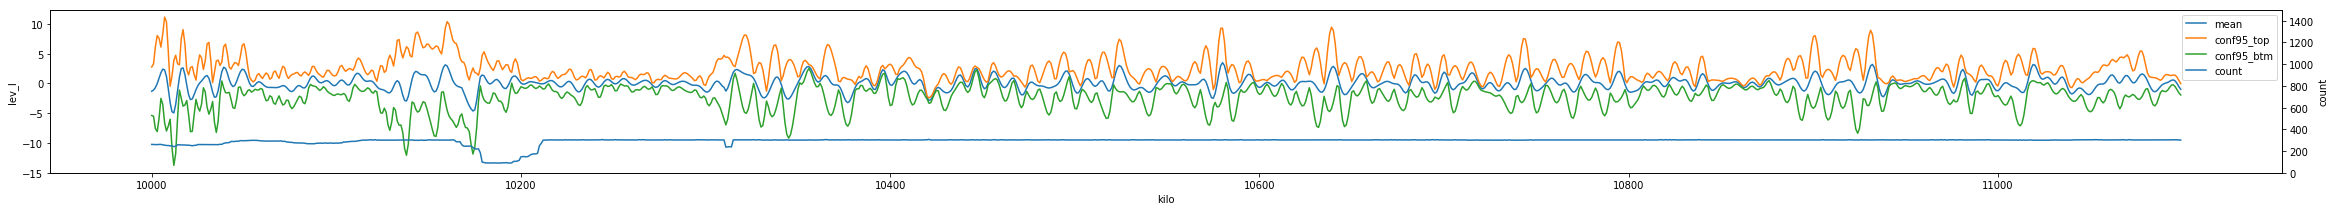

In [14]:
plot_mean_by_kilo(track['a'].query('kilo<11100'))

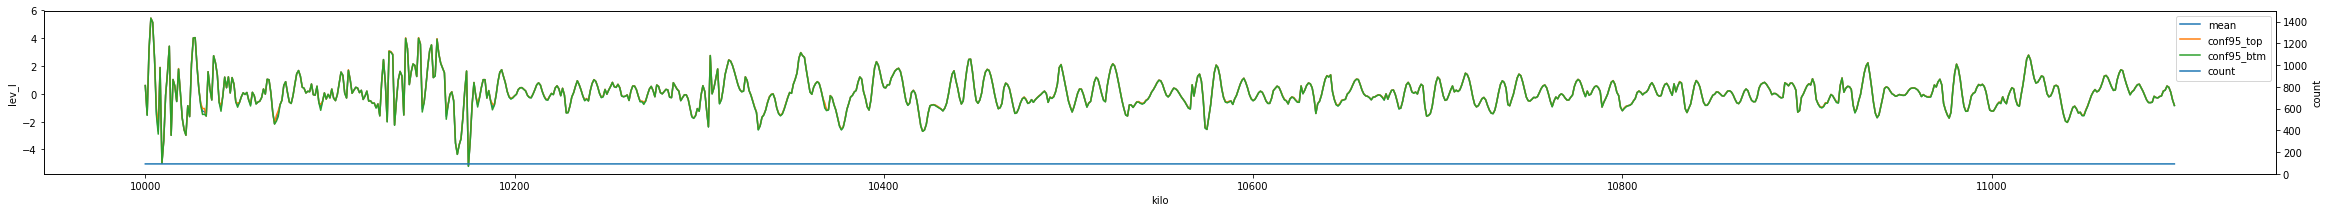

In [15]:
plot_mean_by_kilo(track_pred['a'].query('kilo<11100'))

## Plot properties by kilo

In [32]:
def plot_all_by_kilo(abcd='a', qry_expr='kilo<11000', track=track, equ=equ):
    track = track[abcd].query(qry_expr)
    equ = equ[abcd].query(qry_expr)
    
    # mean, sd, count
    lev_l_gb_count = track.groupby('kilo')['lev_l'].count().rename('count')
    lev_l_gb_mean = track.groupby('kilo')['lev_l'].mean().rename('mean')
    lev_l_gb_std = track.groupby('kilo')['lev_l'].std().rename('std')
    lev_l_gb_conf95_top = (lev_l_gb_mean + 1.96 * lev_l_gb_std).rename('conf95_top')
    lev_l_gb_conf95_btm = (lev_l_gb_mean - 1.96 * lev_l_gb_std).rename('conf95_btm')

    fig, (ax1_1, ax2, ax3, ax4_1, ax5_1) = plt.subplots(5, 1, figsize=(28,13))
    ax1_1.plot(lev_l_gb_mean.index, lev_l_gb_mean)
    ax1_1.plot(lev_l_gb_mean.index, lev_l_gb_conf95_top)
    ax1_1.plot(lev_l_gb_mean.index, lev_l_gb_conf95_btm)
    ax1_1.set_ylim(bottom=-10, top=10)
    ax1_2 = ax1_1.twinx()
    ax1_2.plot(lev_l_gb_count.index, lev_l_gb_count)
    ax1_2.set_ylim(bottom=0, top=1500)
    ax1_1.set_ylabel('lev_l')
    ax1_2.set_ylabel('count')
    h1_1, l1_1 = ax1_1.get_legend_handles_labels()
    h1_2, l1_2 = ax1_2.get_legend_handles_labels()
    ax1_1.legend(h1_1+h1_2, l1_1+l1_2, loc='upper right')
    ax1_1.grid(True)

    # bool valuables
    bool_cols = ['is_ballast', 'is_long', 'is_bridge', 'is_unreliable']
    i = 0
    for col in bool_cols:
        equ_bool = equ.query('{}==1'.format(col))
        ax2.scatter(equ_bool['kilo'], equ_bool[col].astype('int') - i, s=300, marker='|')
        i += 1
    ax2.legend(loc='upper right')
    ax2.grid(True, axis='x')

    # sleeper_types
    sleeper_type = pd.get_dummies(equ['sleeper_type'])
    sleeper_type = pd.concat([equ['kilo'], sleeper_type], axis=1)
    i = 0
    for col in sleeper_type.columns[1:]:
        slep_bool = sleeper_type.query('{}==1'.format(col))
        ax3.scatter(slep_bool['kilo'], slep_bool[col].astype('int') - i, s=200, marker='|')
        i += 1
    ax3.legend(loc='upper right')
    ax3.grid(True, axis='x')

    # gross_ton, radius
    ax4_1.plot(equ['kilo'], equ['gross_ton'])
    ax4_1.set_ylim(bottom=0, top=12)
    ax4_2 = ax4_1.twinx()
    ax4_2.plot(equ['kilo'], equ['radius'], c='g')
    ax4_2.set_ylim(bottom=10000, top=0)
    ax4_1.set_xlabel('kilo')
    ax4_1.set_ylabel('gross_ton')
    ax4_2.set_ylabel('radius')
    h4_1, l4_1 = ax4_1.get_legend_handles_labels()
    h4_2, l4_2 = ax4_2.get_legend_handles_labels()
    ax4_1.legend(h4_1+h4_2, l4_1+l4_2, loc='upper right')
    ax4_1.grid(True, axis='x')

    # cant, speed
    lev_l_gb_cant = track.groupby('kilo')['cant'].mean()
    lev_l_gb_speed = track.groupby('kilo')['speed'].mean()

    ax5_1.plot(lev_l_gb_cant.index, lev_l_gb_cant)
    ax5_1.set_ylim(bottom=-5, top=5)
    ax5_2 = ax5_1.twinx()
    ax5_2.plot(lev_l_gb_speed.index, lev_l_gb_speed, c='g')
    ax5_2.set_ylim(bottom=0, top=120)
    ax5_1.set_ylabel('cant')
    ax5_2.set_ylabel('speed')
    h5_1, l5_1 = ax5_1.get_legend_handles_labels()
    h5_2, l5_2 = ax5_2.get_legend_handles_labels()
    ax5_1.legend(h5_1+h5_2, l5_1+l5_2, loc='upper right')
    ax5_1.grid(True)

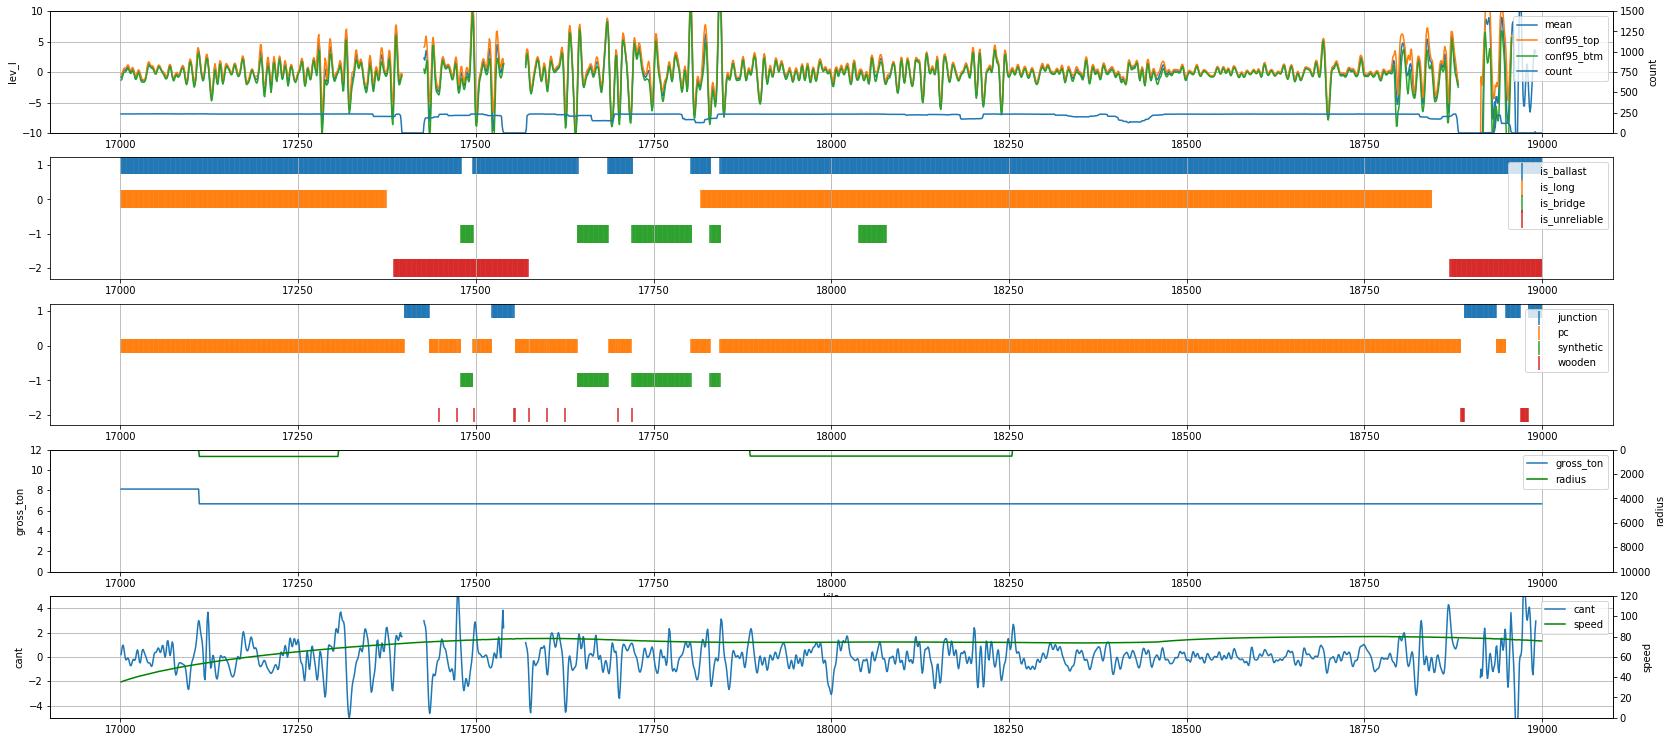

In [33]:
plot_all_by_kilo(abcd='b', qry_expr='17000<kilo<19000')

## Visutalize NA

In [8]:
def show_heatmap(df):
    plt.figure(figsize=(20, 6))
    sns.heatmap(df.notnull(), cbar=False)

In [9]:
def rolling_fillna(track_pv, r_num=4):
    track_pv_fill = track_pv.copy()
    for i in range(r_num):
        fill_method = 'ffill' if i%4 < 2 else 'bfill'
        fill_axis = 0 if i%2 == 0 else 1
        track_pv_fill = track_pv_fill.fillna(method=fill_method, axis=fill_axis, limit=1)
        return track_pv_fill

In [20]:
track_pv = track['d'].pivot(index='date', columns='kilo', values='lev_l')

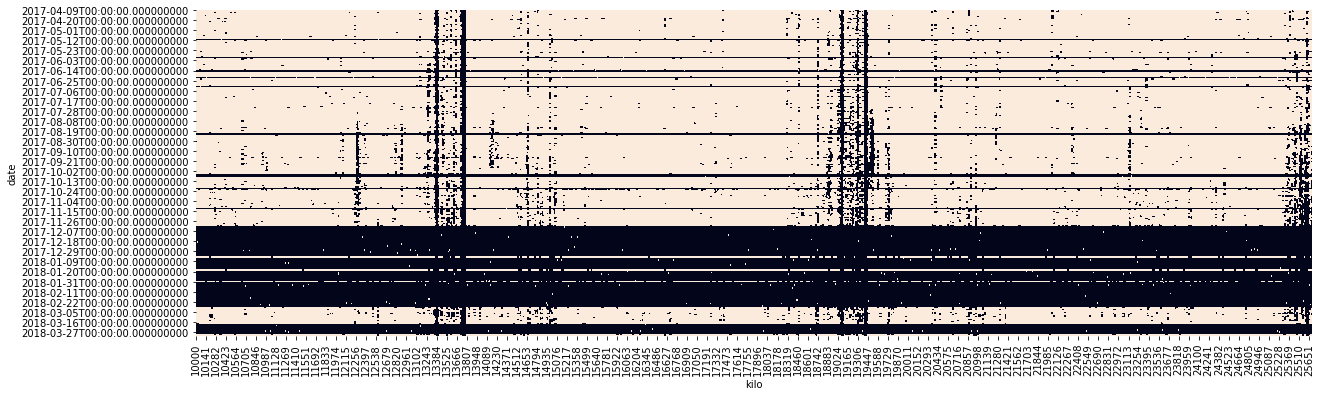

In [21]:
show_heatmap(rolling_fillna(track_pv, r_num=10))

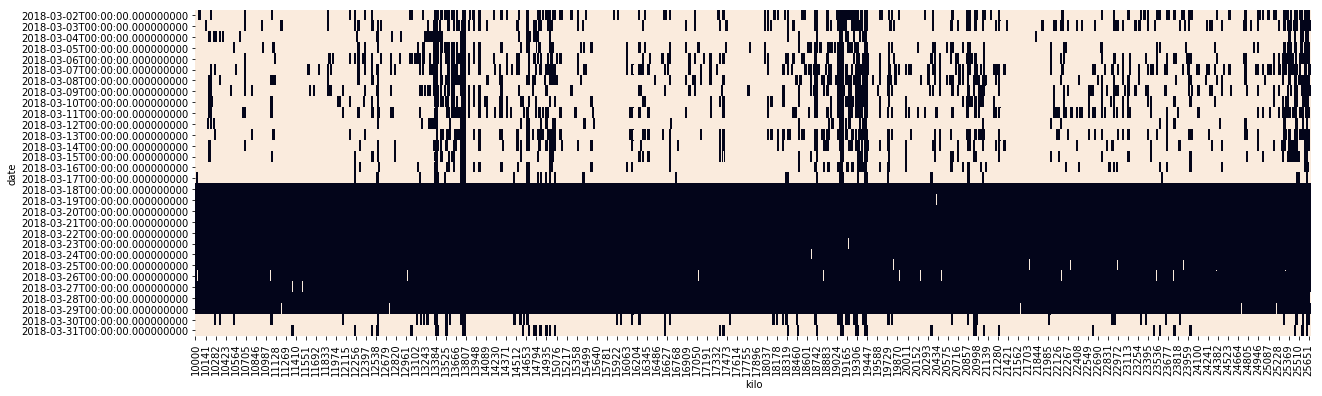

In [22]:
show_heatmap(track_pv.query('date>"2018-03-01"'))

In [55]:
track['b'].dropna(subset=['lev_l']).groupby('kilo')['date'].max().value_counts().head()

2018-03-18    9410
2018-03-19    9186
2018-03-05    2190
2018-03-04      70
2018-03-17      54
Name: date, dtype: int64